In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harlichristian","key":"9070f975c5fde31954d5d1613203b5af"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
ls ~/.kaggle -la

total 16
drwxr-xr-x 2 root root 4096 Oct  3 13:51 ./
drwx------ 1 root root 4096 Oct  3 13:51 ../
-rw------- 1 root root   70 Oct  3 13:51 kaggle.json


In [4]:
!kaggle datasets download -d andrewmvd/animal-faces

100% 694M/696M [00:22<00:00, 22.0MB/s]
100% 696M/696M [00:22<00:00, 32.4MB/s]


In [5]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import os
import zipfile
import shutil

In [6]:
local_zip = '/content/animal-faces.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [7]:
main_dir = os.path.join('/content/afhq/train')
print(os.listdir(main_dir))

['dog', 'cat', 'wild']


In [9]:
from PIL import Image
sample_count = 0

for x in os.listdir(main_dir):
  dir = os.path.join('/content/afhq/train/', x)
  y = len(os.listdir(dir))
  print(x+':', y)
  sample_count = sample_count + y
  
  img_name = os.listdir(dir)
  for z in range(5):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')


print('\nSample Count:', sample_count)

dog: 4739
- (512, 512)
- (512, 512)
- (512, 512)
- (512, 512)
- (512, 512)
---------------
cat: 5153
- (512, 512)
- (512, 512)
- (512, 512)
- (512, 512)
- (512, 512)
---------------
wild: 4738
- (512, 512)
- (512, 512)
- (512, 512)
- (512, 512)
- (512, 512)
---------------

Sample Count: 14630


In [10]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

In [11]:
batch_size = 128 

train_gen = train_datagen.flow_from_directory(
    main_dir,
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = batch_size,
    subset = 'training'
)

val_gen = train_datagen.flow_from_directory(
    main_dir,
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = batch_size,
    subset = 'validation'
)

Found 11706 images belonging to 3 classes.
Found 2924 images belonging to 3 classes.


In [12]:
model = tf.keras.models.Sequential([
    # First Conv
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Second Conv
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third Conv
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.92):
      print("\nValidation Accuracy is above 92%!")
      self.model.stop_training = True

callbacks = myCallback()

In [14]:
history = model.fit(train_gen, 
                    epochs = 40, 
                    steps_per_epoch = 11706//batch_size, 
                    validation_data = val_gen, 
                    verbose = 1, 
                    validation_steps = 2924//batch_size,
                    callbacks = [callbacks])

Epoch 1/40
91/91 [==============================] - 759s 8s/step - loss: 1.0740 - accuracy: 0.5155 - val_loss: 0.8471 - val_accuracy: 0.6101
Epoch 2/40
91/91 [==============================] - 759s 8s/step - loss: 0.5036 - accuracy: 0.8048 - val_loss: 0.3490 - val_accuracy: 0.8647
Epoch 3/40
91/91 [==============================] - 761s 8s/step - loss: 0.3622 - accuracy: 0.8704 - val_loss: 0.4662 - val_accuracy: 0.8157
Epoch 4/40
91/91 [==============================] - 759s 8s/step - loss: 0.2412 - accuracy: 0.9095 - val_loss: 0.2556 - val_accuracy: 0.8963
Epoch 5/40
91/91 [==============================] - 758s 8s/step - loss: 0.2077 - accuracy: 0.9255 - val_loss: 0.2171 - val_accuracy: 0.9197
Epoch 6/40
91/91 [==============================] - ETA: 0s - loss: 0.1796 - accuracy: 0.9362
Validation Accuracy is above 92%!
91/91 [==============================] - 760s 8s/step - loss: 0.1796 - accuracy: 0.9362 - val_loss: 0.1825 - val_accuracy: 0.9339


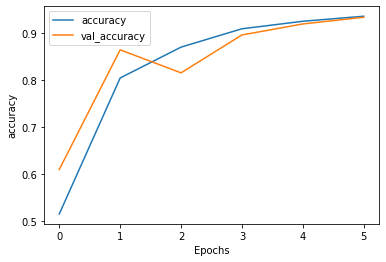

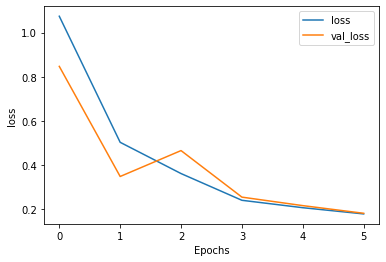

In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpmtqao4ae/assets


In [17]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)